# INPUT SECTION

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate the rainfall-evapoation time-series
values = [
0.   ,  1.   ,  0.6  ,  0.8  ,  0.5  ,  0.1  ,  0.3  ,  0.6  ,
        0.7  ,  0.4  , -0.1  , -0.05 , -0.1  , -0.15 , -0.05 , -0.14 ,
       -0.05 ,  0.   , -0.05 , -0.07 , -0.05 , -0.04 , -0.01 , -0.03 ,
       -0.005, -0.03 , -0.04 , -0.02 , -0.01 , -0.005,  0.   ,  0.   ,
        0.   ,  0.   ,  0.8  ,  1.5  ,  0.5  ,  0.7  , -0.18 , -0.16 ,
       -0.05 , -0.05 , -0.1  , -0.04 , -0.02 , -0.005, -0.01 , -0.005,
       -0.005, -0.05 , -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.8  ,  1.4  ,  1.2 
]

rain_evap = np.array(values)
rain_evap #values are already in cm/day

# Glendale clay loam
def setpars():
    pars={}
    pars['thetaR']=0.1060
    pars['thetaS']=0.4686
    pars['alpha']=0.0104
    pars['n']=1.3954
    pars['m']=1-1/pars['n']
    pars['Ks']=13.1
    pars['Ss']=1e-6
    return pars

pars=setpars()

qT=rain_evap*-1
t=np.arange(len(qT))
dt=1
nt=len(t)

# Spatial grid:
zN=180
z=np.arange(dz/2,zN,dz)
n=len(z)

# Initialize array:
psi=np.zeros((nt,n))

# ICs:
psi[0,:]=-10000

# MODEL SET UP

In [13]:
# DEPENDENT VARIABLES CALCULATION
def Cfun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    x6=1+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1-x4
    x2=x3**2.
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

def solverfun(R,C,Kmid,dt,dz,n):
    # Initialize arrays
    a=np.zeros(n)
    b=np.zeros(n)
    c=np.zeros(n)
    y=np.zeros(n)

    # Construct matrix
    a=-Kmid[:-1]/dz
    b=(Kmid[:-1]+Kmid[1:])/dz+C*dz/dt
    c=-Kmid[1:]/dz

    # Lower boundary:
    b[0]=Kmid[1]/dz+C[0]*dz/dt

    # Upper boundary:
    b[-1]=Kmid[-2]/dz+C[-1]*dz/dt

    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=R[:]

    # Boundary conditions - nothing to do
    #y[0]=y[0]
    #y[-1]=y[-1]

    # Solve:
    dell = np.linalg.solve(A, y)

    return dell

def Rfun(psiiter,psiin,qT,KB,C,Kmid,dtheta,dt,dz,n):
    # This solves the Picard residual term:
    zero=np.array([0])
    psigrid=np.hstack((zero,psiiter,zero))

    x1=-dtheta/dt*dz
    x2=(Kmid[1:]-Kmid[:-1])
    x3=Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz
    x4=-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz

    # Lower boundary:
    x2[0]=Kmid[1]
    x4[0]=-KB

    # Upper boundary:
    x2[-1]=-Kmid[-2]
    x3[-1]=-qT

    R=x1+x2+x3+x4

    return R

def iterfun(psiin,pars,qT,dt,dz,n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=10000
    zero=np.array([0])
    
    # Initialize arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    count=0
    while count <= maxcount:
        # Get C,K:
        C=Cfun(psiiter,pars)
        K=Kfun(np.hstack((zero, psiiter, zero)),pars)
        Kmid=(K[1:]+K[:-1])/2
        dtheta=thetafun(psiiter,pars)-thetafun(psiin,pars)
        # Get R
        R=Rfun(psiiter,psiin,qT,K[1],C,Kmid,dtheta,dt,dz,n)
        # Solve for del
        dell=solverfun(R,C,Kmid,dt,dz,n)
        # Update psi estimates at different iteration levels
        psiout[:]=psiiter[:]+dell[:]
        
        psiiter[:]=psiout[:]
        
        # Check for convergence
        if np.max(np.abs(R)) < tolerance:
            break
        
        count+=1
        
    return psiout

def massbal(psi,qT,pars,n,dt,dz):

    # Initial storage:
    theta=thetafun(psi.reshape(-1),pars)
    theta=np.reshape(theta,psi.shape)
    S=np.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=Kfun(psi[:,0],pars)
    QIN=-Kin
    QIN[0]=0
    QINsum=np.sum(QIN)*dt

    # Outflow:
    QOUT=qT
    QOUT[0]=0
    QOUTsum=np.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun(dt,dz,n,nt,psi,qT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun(psi[j-1,:],pars,qT[j],dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,qT,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

# SIMULATION RUN

In [14]:
psi,QIN,QOUT,S,err=ModelRun(dt,2,n,nt,psi,qT,pars)
n, z, nt, err, psi[59]

(90,
 array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
         23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
         45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
         67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
         89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
        111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
        133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
        155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
        177., 179.]),
 60,
 1.0000000000000018,
 array([-10000.        , -10000.        , -10000.        , -10000.        ,
        -10000.        , -10000.        , -10000.        , -10000.        ,
        -10000.        , -10000.        , -10000.        , -10000.        ,
        -10000.        , -10000.        , -10000.        , -10000.        ,
        -10000.        , -10000.        , -10000.  

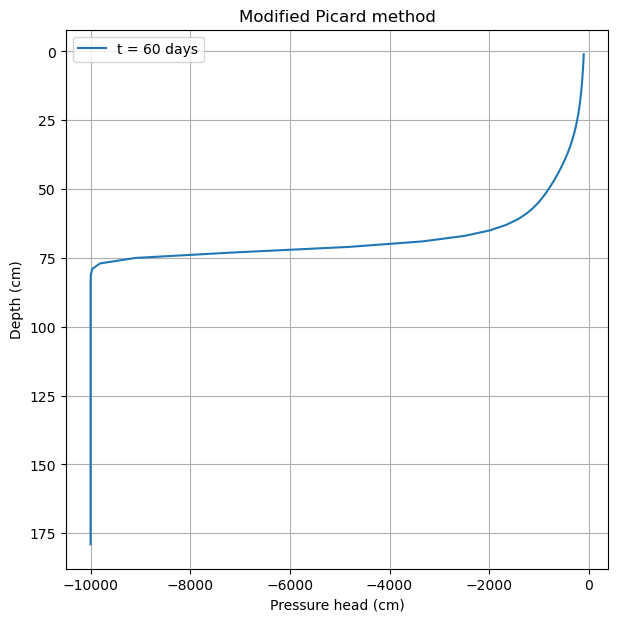

In [15]:
# Modify z to represent depth
plt.figure(figsize=(7, 7))
z_depth = np.flip(z)
psi_plot = plt.plot(psi[59], z_depth, label='t = 60 days') # Plot z vs psi for each dti
plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

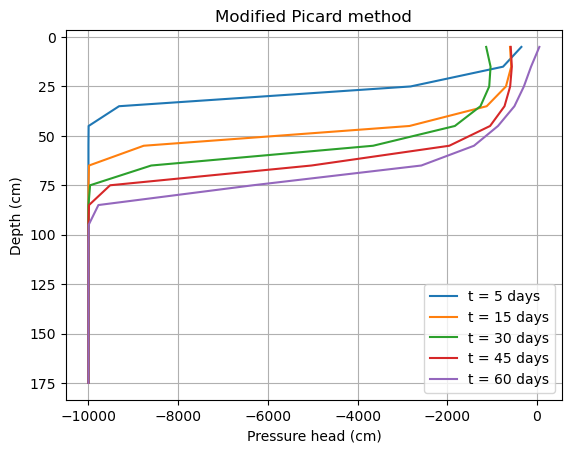

In [109]:
# Specify the time steps you want to plot
time_steps = [4, 14, 29, 44, 59]  # Adjusted for zero-indexing

# Loop through the specified time steps
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t+1} days')  # t+1 because of zero-indexing but your days start from 1

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()